### Possibilistic k-means

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv

In [2]:
class PossibilisticKMeans:
    def __init__(self, groups, dimensions=2, epsilon=0.01):
        self.groups = groups
        self.epsilon = epsilon
        self.dimensions = dimensions

    def select_random_centers(self):
        self.centers = np.random.rand(self.groups, self.dimensions)
    
    def mahalonobis_distance(self, x, y, cov):
        return np.dot(np.dot((x - y).T, cov), x - y)
    
    #returns non zero values
    def d_ikA(self, x, v, A):
        d = np.zeros((self.groups, len(x)))
        for k in range(len(x)):
            for i in range(self.groups):
                d[i][k] = self.mahalonobis_distance(x[k], v[i], A)
        # not to devide by zero
        d = np.fmax(d, np.finfo(x.dtype).eps)
        return d
    
    #u - centers x n_setsize
    def calculate_new_centers(self, u, x, m): 
        um = u**m
        divisor = np.sum(um, axis=1)
        new_centers = np.dot(um, x)
        new_centers /= np.atleast_2d(divisor).T
        return new_centers
    
    def etas(self, u, d, m):
        um = u**m
        divisor = np.sum(um, axis=1)
        eta_i = np.sum(um * d, axis=1)
        eta_i /= divisor
        return eta_i
    
    def fuzzy_k_means_step(self, x, v, m):
        d = self.d_ikA(x, v, np.eye(self.dimensions))
        u = (1 / d) ** (1 / (m-1))
        return d, (u / u.sum(axis=0))
    
    def calculate_u(self, x, d, etas, m):
        d = self.d_ikA(x, self.centers, np.eye(self.dimensions))
        result = 1 + (d / etas) ** (1. / (m - 1))
        return 1./ result
    
    def cluster_fcm(self, x, error, m, max_iter):
        self.select_random_centers()
        i = 0
        while i < max_iter:
            d, u = self.fuzzy_k_means_step(x, self.centers, m)
            self.centers = self.calculate_new_centers(u, x, m)
            i += 1
        return d, u
        
    def setup(self, x, m, error, max_iter):
        d, u = self.cluster_fcm(x, error, m, max_iter)
        return u, self.etas(u, d, m).reshape(self.groups, 1)
    
    def cluster(self, x, error, m, max_iter):
        u, etas = self.setup(x, m, error, max_iter)
        i = 0
        while i < max_iter:
            self.centers = self.calculate_new_centers(u, x, m)
            old_u = u
            u = self.calculate_u(x, u, etas, m)
            if np.linalg.norm(u - old_u) < error:
                break
            old_centers = self.centers
            i = i + 1
        return u

In [3]:
def map_to_colors(assignation, colors):
    colors_assigned = np.argmax(assignation, axis=0)
    colors_map = dict([(colors[i], []) for i in range(len(colors))])
    [colors_map[colors[colors_assigned[i]]].append(i) for i in range(len(colors_assigned))]
    return colors_map

In [4]:
possible_colors = ['blue','red','green', 'orange']

In [5]:
import sklearn.datasets as ds
data_set = ds.make_blobs(206, 2, len(possible_colors))
possibilistic = PossibilisticKMeans(len(possible_colors))
possibilistic.select_random_centers()
u = possibilistic.cluster(data_set[0], 0.001, 2, 180)
centers = possibilistic.centers
cmap = map_to_colors(u, possible_colors)

# Plot results

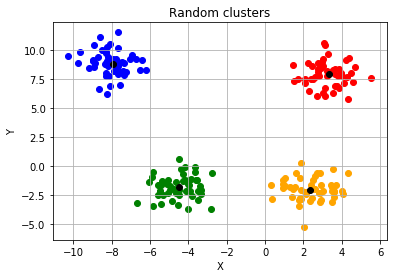

In [6]:
centers = possibilistic.centers
fig, ax = plt.subplots()

colors_array = [np.array(data_set[0][cmap[c]]) for c in possible_colors]

for i, arr in enumerate(colors_array):
    ax.scatter(arr[:,0], arr[:,1], c=possible_colors[i])
ax.scatter(centers[:,0],centers[:,1],c='black')
ax.set(xlabel='X', ylabel='Y',
       title='Random clusters')
ax.grid()
plt.show()